In [150]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Activation, Dense, Flatten, Conv1D, Add, BatchNormalization,LayerNormalization
from tensorflow.keras.layers import Dropout,MaxPooling1D,Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import SeparableConv1D 
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.initializers import he_normal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd #csv
from sklearn.model_selection import train_test_split #June 6, 2024
from tensorflow.keras.utils import to_categorical #June 6, 2024
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
#from tqdm.auto import tqdm #progress bar
from scipy.io import loadmat
import os # path issues

In [ ]:
data_path = r"C:\PQD_with noise"
snr_levels = ["50dB", "40dB", "30dB", "20dB"]
#snr_levels = ["40dB"]
 
disturbance_labels = {
    'Normal': [0, 0, 0, 0, 0, 0],
    'Flicker': [1, 0, 0, 0, 0, 0],
    'Swell': [0, 1, 0, 0, 0, 0],
    'Sag': [0, 0, 1, 0, 0, 0],
    'Interruption': [0, 0, 0, 1, 0, 0],
    'Harmonics': [0, 0, 0, 0, 1, 0],
    'Oscillatory transient': [0, 0, 0, 0, 0, 1],
    'Flicker+Swell': [1, 1, 0, 0, 0, 0],
    'Flicker+Sag': [1, 0, 1, 0, 0, 0],
    'Flicker+Harmonics': [1, 0, 0, 0, 1, 0],
    'Flicker+Transient': [1, 0, 0, 0, 0, 1],
    'Swell+Harmonics': [0, 1, 0, 0, 1, 0],
    'Swell+Transient': [0, 1, 0, 0, 0, 1],
    'Sag+Harmonics': [0, 0, 1, 0, 1, 0],
    'Sag+Transient': [0, 0, 1, 0, 0, 1],
    'Interruption+Harmonics': [0, 0, 0, 1, 1, 0],
    'Flicker+Swell+Harmonics': [1, 1, 0, 0, 1, 0],
    'Flicker+Sag+Harmonics': [1, 0, 1, 0, 1, 0],
    'Swell+Harmonics+Transient': [0, 1, 0, 0, 1, 1],
    'Sag+Harmonics+Transient': [0, 0, 1, 0, 1, 1]
}

In [109]:
# Function to load data
def load_data():
    X = []
    y = []
    for snr in snr_levels:
        folder_path = os.path.join(data_path, snr)
        for file in os.listdir(folder_path):
            if file.endswith('.xlsx'):
                file_path = os.path.join(folder_path, file)
                df = pd.read_excel(file_path, header=None,engine='openpyxl')
                df = df.iloc[:500, :]  # Select only the first 500 rows #Jun 8, to be changed to 600
                X.append(df.values)
                label_name = os.path.splitext(file)[0]
                y.append(disturbance_labels[label_name])
    X = np.concatenate(X, axis=0)
    y = np.repeat(y, 500, axis=0) # Repeat each label 600 times
    return X, y
 
X, y = load_data()
X = X.reshape(-1, 640, 1)  # Reshape for CNN input
 
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [140]:
#X = X.reshape(-1, 640, 1)  # Reshape for CNN input
print(y_test[0:5])
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
#X_train.shape
#y_train.shape

[[0 0 1 0 1 1]
 [0 1 0 0 0 1]
 [1 0 1 0 0 0]
 [0 0 1 0 1 0]
 [0 1 0 0 1 1]]
X_train shape: (24000, 640, 1)
X_val shape: (8000, 640, 1)
X_test shape: (8000, 640, 1)


In [111]:
X_train = X_train.reshape(-1, 640, 1)
print(f"X_train shape: {X_train.shape}")
X_val = X_val.reshape(-1, 640, 1)
print(f"X_train shape: {X_val.shape}")
X_test = X_test.reshape(-1, 640, 1)
print(f"X_train shape: {X_test.shape}")

X_train shape: (24000, 640, 1)
X_train shape: (8000, 640, 1)
X_train shape: (8000, 640, 1)


In [147]:
# Build the model
input_shape = (640, 1)
model = build_resnet(input_shape)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 640, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_180 (Conv1D)             (None, 320, 64)      512         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 320, 64)      256         conv1d_180[0][0]                 
__________________________________________________________________________________________________
activation_156 (Activation)     (None, 320, 64)      0           batch_normalization_180[0][0]    
___________________________________________________________________________________________

In [148]:
# Compile the model
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=200, decay_rate=0.6, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [138]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    """
    Residual block with identity shortcut.
    """
    shortcut = x
    if conv_shortcut:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same',kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)
 
    x = Conv1D(filters, kernel_size, strides=stride, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
 
    x = Conv1D(filters, kernel_size, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
 
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
 
    return x
 
def build_resnet(input_shape, num_classes=6):
    """
    Build a 1D ResNet model.
    """
    input_layer = Input(shape=input_shape)
 
    x = Conv1D(64, 7, strides=2, padding='same',kernel_initializer='he_normal')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
 
    x = residual_block(x, 64)
    x = residual_block(x, 64)
 
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)
 
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)
 
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x) 
    x = Dene(num_classes, activation='sigmoid',kernel_initializer='he_normal')(x)
 
    model = Model(inputs=input_layer, outputs=x)
    return model

In [149]:
history = model.fit(X_train, y_train, epochs=20, batch_size=120, validation_data=(X_val, y_val))

Train on 24000 samples, validate on 8000 samples
Epoch 1/20
24000/24000 [==============================] - 205s 9ms/sample - loss: 0.1730 - accuracy: 0.9310 - val_loss: 1.0138 - val_accuracy: 0.7813
Epoch 2/20
24000/24000 [==============================] - 223s 9ms/sample - loss: 0.0826 - accuracy: 0.9718 - val_loss: 0.2715 - val_accuracy: 0.9221
Epoch 3/20
24000/24000 [==============================] - 218s 9ms/sample - loss: 0.0609 - accuracy: 0.9803 - val_loss: 0.2105 - val_accuracy: 0.9352
Epoch 4/20
24000/24000 [==============================] - 219s 9ms/sample - loss: 0.0497 - accuracy: 0.9840 - val_loss: 0.0383 - val_accuracy: 0.9886
Epoch 5/20
24000/24000 [==============================] - 224s 9ms/sample - loss: 0.0431 - accuracy: 0.9868 - val_loss: 0.0365 - val_accuracy: 0.9876
Epoch 6/20
24000/24000 [==============================] - 234s 10ms/sample - loss: 0.0383 - accuracy: 0.9882 - val_loss: 0.0325 - val_accuracy: 0.9904
Epoch 7/20
24000/24000 [==========================

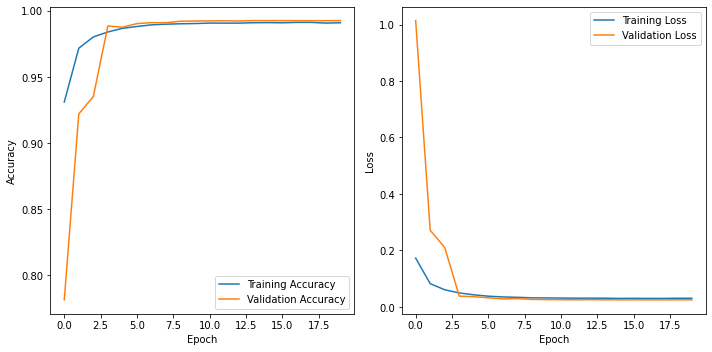

In [153]:
plt.figure(figsize=(10, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
 
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
plt.tight_layout()
plt.show()

In [151]:
#save the model
import os.path
if os.path.isfile('Models/ResNet50.h5') is False:
    model.save('Models/ResNet50.h5')

In [154]:
from sklearn.metrics import classification_report, accuracy_score
import time

# Function to load data for a specific SNR level
def load_data_for_snr(snr, limit_rows=100):
    X = []
    y = []
    folder_path = os.path.join(data_path, snr)
    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_excel(file_path, header=None, engine='openpyxl')
            df = df.iloc[-limit_rows:, :]  # Select only the last 100 rows
            X.append(df.values)
            label_name = os.path.splitext(file)[0]
            y.append(disturbance_labels[label_name])
    X = np.concatenate(X, axis=0)
    y = np.repeat(y, limit_rows, axis=0)  # Repeat each label `limit_rows` times
    X = X.reshape(-1, 640, 1)  # Reshape for 1D CNN input
    return X, y

# Function to evaluate model on different SNR levels
def evaluate_on_snr_levels(model, snr_levels):
    for snr in snr_levels:
        X, y = load_data_for_snr(snr)
        start_time = time.time()
        y_pred = model.predict(X)
        end_time = time.time()
        sample_time = (end_time - start_time) / len(X)  # Calculate time per sample
        y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
        accuracy = accuracy_score(y, y_pred)
        report = classification_report(y, y_pred, target_names=['Flicker', 'Swell', 'Sag', 'Interruption', 'Harmonics', 'Oscillatory transient'], zero_division=1)
       # report = classification_report(y, y_pred, target_names=list(disturbance_labels.keys()))
        print(f'SNR: {snr} - Accuracy: {accuracy}')
        print(f'Average Time per Sample for SNR {snr}: {sample_time:.6f} seconds')
        print(f'Classification Report for SNR {snr}:\n{report}')
        
# Evaluate the model on test data from different SNR levels
evaluate_on_snr_levels(model, snr_levels)

KeyboardInterrupt: 

In [ ]:
#test_signals_reshaped = test_signals.reshape(test_signals.shape[0], test_signals.shape[1], 1)
predictions = model.predict(
    x=test_signals_reshaped, #test_labels,
    batch_size=160,
    verbose=0
)